# How To Export a Model Trained in Supervisely

After you have trained a model using Supervisely application, you can download its weights and config file, and use the model outside Supervisely Platform.

## 1. Download model weights and config from Team Files

**1. Go to Team Files:**

![Team Files](https://github.com/supervisely-ecosystem/mmsegmentation/assets/31512713/678fbf96-e16c-449d-9e5d-1ae4efc8a796)

**2. Download model weights and config file:**

![Download model](https://github.com/supervisely-ecosystem/hrda/assets/31512713/c0eb79b5-7cd8-4897-9d8b-22fd4e27313b)

**Alternatively, you can download these files using Supervisely API:**

In [ ]:
# Install supervisely SDK if not installed
!pip install supervisely

In [ ]:
# Fill in these arguments:
server_address = "https://..."
api_token = "abcd0123456789..."
team_id = ...
path_to_weights_in_team_files = ...
path_to_config_in_team_files = ...
download_dir = "./my_model"

import supervisely as sly
api = sly.Api(server_address, api_token)
api.file.download(team_id, path_to_weights_in_team_files, f"{download_dir}/weights.pth")
api.file.download(team_id, path_to_config_in_team_files, f"{download_dir}/config.py")

## 2. Install requirements

**You can use our pre-builded docker image:**

`supervisely/hrda:1.0.0`

**Alternatively, install requirements manually with pip:**

In [ ]:
!pip install -r requirements_full.txt

## 3. Build the model

After you've installed requirements and downloaded model weights and config, **fill in the paths** where the files located:

In [1]:
# Put your paths here:
weights_path = "my_model/weights.pth"
config_path = "my_model/config.py"

device = "cuda:0"

In [2]:
from mmseg.apis.inference import init_segmentor, LoadImage
from mmseg.datasets.pipelines import Compose

model = init_segmentor(
    config_path,
    weights_path,
    device=device,
    revise_checkpoint=[(r"^module\.", ""), ("model.", "")],
)
cfg = model.cfg
classes, palette = model.CLASSES, model.PALETTE
test_pipeline_cfg = [LoadImage()] + cfg.data.test.pipeline[1:]
test_pipeline = Compose(test_pipeline_cfg)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/hrda/mmseg/models/backbones/mix_transformer.py:216: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '


Use load_from_local loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone.patch_embed1.proj.weight, ema_backbone.patch_embed1.proj.bias, ema_backbone.patch_embed1.norm.weight, ema_backbone.patch_embed1.norm.bias, ema_backbone.patch_embed2.proj.weight, ema_backbone.patch_embed2.proj.bias, ema_backbone.patch_embed2.norm.weight, ema_backbone.patch_embed2.norm.bias, ema_backbone.patch_embed3.proj.weight, ema_backbone.patch_embed3.proj.bias, ema_backbone.patch_embed3.norm.weight, ema_backbone.patch_embed3.norm.bias, ema_backbone.patch_embed4.proj.weight, ema_backbone.patch_embed4.proj.bias, ema_backbone.patch_embed4.norm.weight, ema_backbone.patch_embed4.norm.bias, ema_backbone.block1.0.norm1.weight, ema_backbone.block1.0.norm1.bias, ema_backbone.block1.0.attn.q.weight, ema_backbone.block1.0.attn.q.bias, ema_backbone.block1.0.attn.kv.weight, ema_backbone.block1.0.attn.kv.bias, ema_backbone.block1.0.attn.proj.weight, ema_backbone.block

In [3]:
import torch
import numpy as np
import mmcv
from mmcv.parallel import collate, scatter

def prepare_image(image_path: str, model, device, test_pipeline) -> dict:
    data = dict(img=image_path)
    data = test_pipeline(data)
    data = collate([data], samples_per_gpu=1)
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        data["img_metas"] = [i.data[0] for i in data["img_metas"]]
    return data

def infer(image_path: str, model, device, test_pipeline):
    # Prepare the image
    data = prepare_image(image_path, model, device, test_pipeline)
    
    # Turn off rescale as we will unpad and resize manually
    img_meta = data["img_metas"][0][0]
    ori_shape = img_meta["ori_shape"]
    if img_meta.get("pad_shape"):
        data["rescale"] = False

    # Predict
    with torch.no_grad():
        result = model(return_loss=False, **data)

    # Unpad and Resize manually
    if img_meta.get("pad_shape"):
        h, w, c = img_meta["img_shape"]
        dtype = result[0].dtype
        result = result[0][:h, :w].astype(np.uint8)
        # "nearest" interpolation can shift mask slightly
        # that leads to inaccurate mask on borders.
        # The alternative solution is to predict the image in its original size.
        result = mmcv.imresize(result, ori_shape[:2][::-1], interpolation="nearest")
        result = result.astype(dtype)
    
    return [result]

## 4. Inference

In [5]:
image_path = "resources/crack.jpg"
result = infer(image_path, model, device, test_pipeline)
result

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

## 5. Visualize

/root/hrda/mmseg/models/segmentors/base.py:258: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


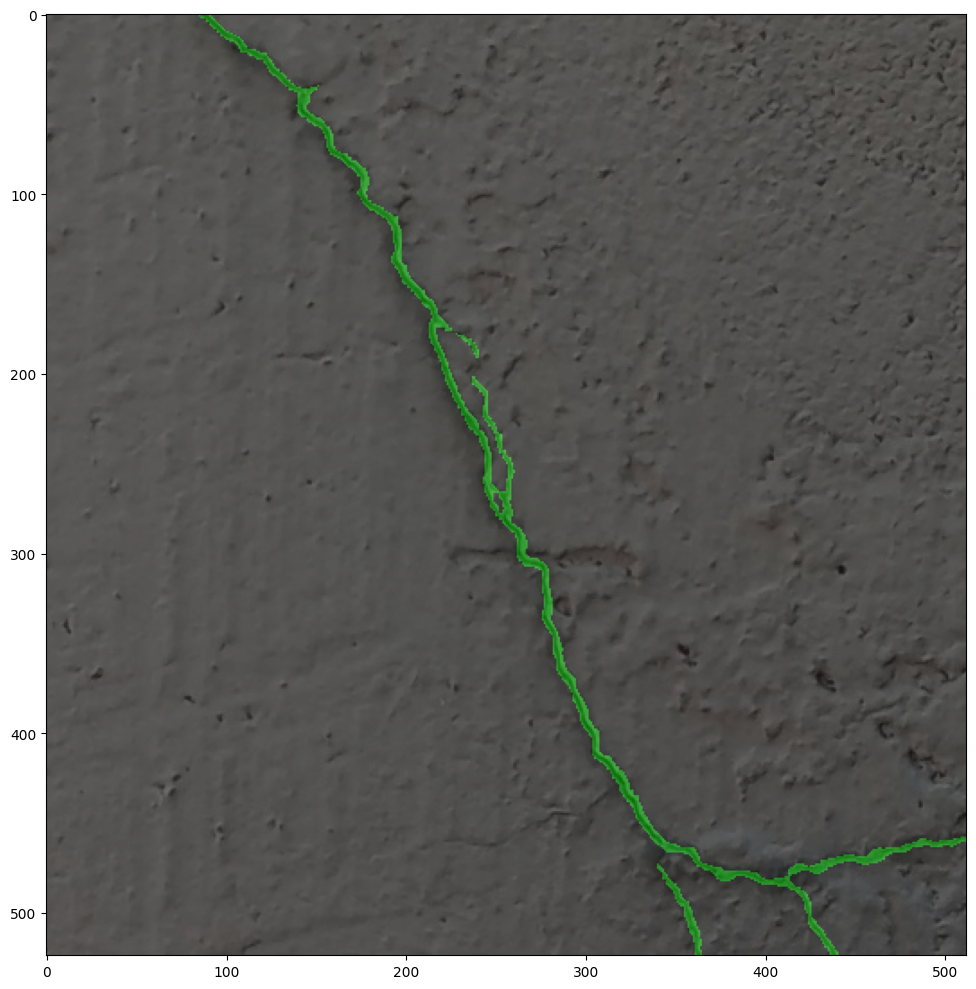

In [6]:
from mmseg.apis.inference import show_result_pyplot

show_result_pyplot(model, image_path, result, opacity=0.4)